# Lab Assignment Four: The Multi-Layer Perceptron

### Load, Split, and Balance

#### Load Data
Save data into a dataframe. Remove any obervations with missing data. Encode string data as integers

**Data Set** : US Census Data - https://www.kaggle.com/muonneutrino/us-census-demographic-data/dataLinks

In [1]:
#Import all necessary utilities
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy import stats
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
import re
from scipy.special import expit
import sys
warnings.simplefilter('ignore', DeprecationWarning)

#Loading the dataset
data = pd.read_csv('../Data/acs2017_census_tract_data.csv', low_memory=False)

#Showing data
data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74001 entries, 0 to 74000
Data columns (total 37 columns):
TractId             74001 non-null int64
State               74001 non-null object
County              74001 non-null object
TotalPop            74001 non-null int64
Men                 74001 non-null int64
Women               74001 non-null int64
Hispanic            73305 non-null float64
White               73305 non-null float64
Black               73305 non-null float64
Native              73305 non-null float64
Asian               73305 non-null float64
Pacific             73305 non-null float64
VotingAgeCitizen    74001 non-null int64
Income              72885 non-null float64
IncomeErr           72885 non-null float64
IncomePerCap        73256 non-null float64
IncomePerCapErr     73256 non-null float64
Poverty             73159 non-null float64
ChildPoverty        72891 non-null float64
Professional        73190 non-null float64
Service             73190 non-null float64


,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga County,1845,899,946,2.4,86.3,5.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,Alabama,Autauga County,2172,1167,1005,1.1,41.6,54.5,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,Alabama,Autauga County,3385,1533,1852,8.0,61.4,26.5,0.6,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,Alabama,Autauga County,4267,2001,2266,9.6,80.3,7.1,0.5,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,Alabama,Autauga County,9965,5054,4911,0.9,77.5,16.4,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73996,72153750501,Puerto Rico,Yauco Municipio,6011,3035,2976,99.7,0.3,0.0,0.0,...,0.5,0.0,3.6,26.9,1576,59.2,33.8,7.0,0.0,20.8
73997,72153750502,Puerto Rico,Yauco Municipio,2342,959,1383,99.1,0.9,0.0,0.0,...,0.0,0.0,1.3,25.3,666,58.4,35.4,6.2,0.0,26.3
73998,72153750503,Puerto Rico,Yauco Municipio,2218,1001,1217,99.5,0.2,0.0,0.0,...,3.4,0.0,3.4,23.5,560,57.5,34.5,8.0,0.0,23.0
73999,72153750601,Puerto Rico,Yauco Municipio,4380,1964,2416,100.0,0.0,0.0,0.0,...,0.0,0.0,0.0,24.1,1062,67.7,30.4,1.9,0.0,29.5


In [2]:
#Remove all rows with null values
data.dropna(inplace=True);

#Convert all String Values to Integers
data[['State', 'County']] = data[['State', 'County']].apply(lambda x: pd.factorize(x)[0])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72718 entries, 0 to 74000
Data columns (total 37 columns):
TractId             72718 non-null int64
State               72718 non-null int64
County              72718 non-null int64
TotalPop            72718 non-null int64
Men                 72718 non-null int64
Women               72718 non-null int64
Hispanic            72718 non-null float64
White               72718 non-null float64
Black               72718 non-null float64
Native              72718 non-null float64
Asian               72718 non-null float64
Pacific             72718 non-null float64
VotingAgeCitizen    72718 non-null int64
Income              72718 non-null float64
IncomeErr           72718 non-null float64
IncomePerCap        72718 non-null float64
IncomePerCapErr     72718 non-null float64
Poverty             72718 non-null float64
ChildPoverty        72718 non-null float64
Professional        72718 non-null float64
Service             72718 non-null float64
Of

#### Splitting Data
Split the dataset into 80% training and 20% testing

In [3]:
# Creating our data matrix (X) and our target variable (y) that we will work on from the dataframe we have
X = data[['TractId', 'State', 'County', 'TotalPop', 'Men', 'Women', 'Hispanic',
       'White', 'Black', 'Native', 'Asian', 'Pacific', 'VotingAgeCitizen',
       'Income', 'IncomeErr', 'IncomePerCap', 'IncomePerCapErr', 'Poverty',
       'Professional', 'Service', 'Office', 'Construction',
       'Production', 'Drive', 'Carpool', 'Transit', 'Walk', 'OtherTransp',
       'WorkAtHome', 'MeanCommute', 'Employed', 'PrivateWork', 'PublicWork',
       'SelfEmployed', 'FamilyWork', 'Unemployment']].to_numpy()
y = data.ChildPoverty.to_numpy()
print("The shape of the data matrix: " + str(X.shape))
print("The shape of the target variable: " + str(y.shape))

The shape of the data matrix: (72718, 36)
The shape of the target variable: (72718,)


In [4]:
# Dividing the data into training and testing data using an 80% training and 20% testing split.
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.2, random_state=0)
print("The training matrix and target shapes: " + str(X_train.shape)+ ' & ' + str(y_train.shape))
print("The testing matrix and target shapes: " + str(X_test.shape)+ ' & ' + str(y_test.shape))

The training matrix and target shapes: (58174, 36) & (58174,)
The testing matrix and target shapes: (14544, 36) & (14544,)


#### Balancing Data
Balance the dataset so there are the same number of instances within each class. Explain the reasoning of which method you chose.

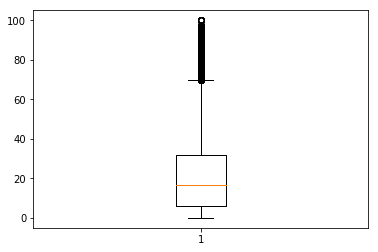

In [5]:
#original split into 4 classes : low, average, high, and extreme poverty
#Graph general boxplot to see break-up
plt.boxplot(y_train)
plt.show()

#Calculate Quartiles
Q1, median, Q3 = np.percentile(np.asarray(y_train), [25, 50, 75])
IQR = Q3 - Q1

loval = Q1 - 1.5 * IQR
hival = Q3 + 1.5 * IQR

#Calculate Classes
#Low is less than Q1, Average is between Q1-Q3, High is between Q3 and highval, extreme are outliers above highval
def classify(row):
    if row['ChildPoverty'] < Q1:
        val = 0
    elif row['ChildPoverty'] < Q3:
        val = 1
    elif row['ChildPoverty'] < hival:
        val = 2
    else : 
        val = 3
    return val

data['cp_class'] = data.apply(classify, axis=1)

#Split again to convert y_train and y_test to classes
y = data.cp_class.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.2, random_state=0)

<BarContainer object of 4 artists>

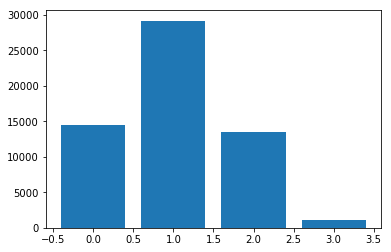

In [6]:
#Make sure there are equal number of instances in each class
#Graph of balance
plt.bar(np.unique(y_train), np.unique(y_train, return_counts=True)[1])

In [7]:
# Making an instance of SMOTE class 
# For oversampling of minority class
from imblearn.over_sampling import SMOTE
smote = SMOTE()
  
# Fit predictor (x variable)
# and target (y variable) using fit_resample()
X_OverSmote, Y_OverSmote = smote.fit_resample(X.copy(), y.copy())
plt.bar(np.unique(Y_OverSmote), np.unique(Y_OverSmote, return_counts=True)[1])

ModuleNotFoundError: No module named 'imblearn'

**Should balancing of the dataset be done for both the training and testing set? Explain.** <br/>
Balancing should be done on just the training dataset and not the testing set. The model has already adjusted for imbalance to have equal awareness of the underrepresented classes, so it does not matter what data it is tested against. Additionally, while we want the data we train on to minimize biases, we do want the data we test against to be a reflection of the true values of the data.

### Pre-processing

#### Two-Layer Perceptron
Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Do not normalize or one-hot encode the data (not yet). Be sure that training converges by graphing the loss function versus the number of epochs. 

In [8]:
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_) # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))
        
        W2_num_elems = (self.n_hidden)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden)
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_) * np.sqrt(np.mean(W1 ** 2) + np.mean(W2 ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term

In [9]:
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # need to vectorize this computation!
        # See additional code and derivation below!
        pass
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2, self.b1, self.b2)
            
            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)

            self.W1 -= self.eta * gradW1
            self.W2 -= self.eta * gradW2
            self.b1 -= self.eta * gradb1
            self.b2 -= self.eta * gradb2
            

        return self

In [10]:
class TwoLayerPerceptronVectorized(TwoLayerPerceptron):
    # just need a different gradient calculation
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C * 2
        gradW2 += W2 * self.l2_C * 2 

        return gradW1, gradW2, gradb1, gradb2

In [11]:
def analyze_two_layer_perceptron(X_train, y_train, X_test, y_test):
    params = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=400, # iterations
              eta=0.001,  # learning rate
              random_state=1)

    nn = TwoLayerPerceptronVectorized(**params)

    nn.fit(X_train, y_train, print_progress=50)
    yhat = nn.predict(X_test)
    print('Accuracy:',accuracy_score(y_test,yhat))

    plt.plot(range(len(nn.cost_)), nn.cost_)
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.show()

Epoch: 400/400

Accuracy: 0.5011688668866887


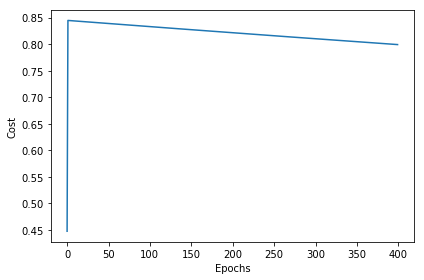

In [12]:
analyze_two_layer_perceptron(X_train, y_train, X_test, y_test)

#### Normalize Numeric Feature Data
Now normalize the continuous numeric feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.  

In [22]:
#Normalize Continuous Numeric Feature Data
from sklearn.preprocessing import Normalizer 
normalizer = Normalizer(norm = 'l2')

normalizer.transform(X)

array([[9.99999997e-01, 0.00000000e+00, 0.00000000e+00, ...,
        4.49541421e-09, 0.00000000e+00, 4.59531231e-09],
       [9.99999999e-01, 0.00000000e+00, 0.00000000e+00, ...,
        8.99082755e-09, 0.00000000e+00, 3.39653485e-09],
       [9.99999999e-01, 0.00000000e+00, 0.00000000e+00, ...,
        4.79510755e-09, 6.99286517e-10, 4.69520947e-09],
       ...,
       [1.00000000e+00, 7.06823965e-10, 2.70672001e-08, ...,
        1.10874347e-10, 0.00000000e+00, 3.18763749e-10],
       [1.00000000e+00, 7.06823964e-10, 2.70672000e-08, ...,
        2.63326575e-11, 0.00000000e+00, 4.08849156e-10],
       [1.00000000e+00, 7.06823964e-10, 2.70672000e-08, ...,
        6.92964670e-11, 0.00000000e+00, 2.48081352e-10]])

In [ ]:
analyze_two_layer_perceptron(X_train, y_train, X_test, y_test)

Epoch: 150/400

#### Normalize Continuous Numeric Feature Data
Now normalize the continuous numeric feature data AND one hot encode the categorical data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs. 

In [ ]:
#One-hot encode categorical data
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)


In [ ]:
analyze_two_layer_perceptron(X_train, y_train, X_test, y_test)

#### Compare Performance
Compare the performance of the three models you just trained. Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have) different performances.  

#### Normalize and One-Code Dataset

### Modeling

#### Third Layer of Perceptron
Add support for saving (and plotting after training is completed) the average magnitude of the gradient for each layer, for each epoch. For magnitude calculation, you are free to use either the average absolute values or the L1/L2 norm. Quantify the performance of the model and graph the magnitudes for each layer versus the number of epochs.

#### Fourth Layer of Perceptron

#### Fifth Layer of Perceptron

#### Adaptive Learning
Implement an adaptive learning technique that was discussed in lecture and use it on the five layer network. Compare the performance of this model with and without the adaptive learning strategy. Do not use AdaM for the adaptive learning technique. 